In [1]:
import os
import json
import torch
import sys
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
from torchvision import transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

from my_dataset import MyDataSet
from vit_model import vit_base_patch16_224_in21k as create_model 

In [2]:
def load_data(data_root):
    assert os.path.exists(data_root), f"Dataset root: {data_root} does not exist."
    test_images_path = []
    test_images_label = []

    flower_class = [cla for cla in os.listdir(data_root) if os.path.isdir(os.path.join(data_root, cla))]
    flower_class.sort()
    class_indices = {k: v for v, k in enumerate(flower_class)}
    
    with open('class_indices.json', 'w') as json_file:
        json.dump({val: key for key, val in class_indices.items()}, json_file, indent=4)

    supported = [".jpg", ".JPG", ".png", ".PNG"]
    for cla in flower_class:
        cla_path = os.path.join(data_root, cla)
        images = [os.path.join(cla_path, i) for i in os.listdir(cla_path) if os.path.splitext(i)[-1] in supported]
        images.sort()
        image_class = class_indices[cla]
        test_images_path.extend(images)
        test_images_label.extend([image_class] * len(images))

    print(f"{len(test_images_path)} images were found in the test dataset.")
    return test_images_path, test_images_label

In [3]:
def main():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    data_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])

    # 加载测试集数据
    data_root = "CIFAR-100/test"  # 数据集根目录
    test_images_path, test_images_label = load_data(data_root)

    # 实例化测试数据集
    test_dataset = MyDataSet(images_path=test_images_path,
                             images_class=test_images_label,
                             transform=data_transform)

    batch_size = 16  # 设置batch size
    num_workers = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])
    test_loader = DataLoader(test_dataset,
                             batch_size=batch_size,
                             shuffle=False,
                             pin_memory=True,
                             num_workers=num_workers,
                             collate_fn=test_dataset.collate_fn)

    # 加载类别索引
    json_path = './class_indices.json'
    assert os.path.exists(json_path), f"File '{json_path}' does not exist."

    with open(json_path, "r") as f:
        class_indict = json.load(f)

    # 加载模型
    model = create_model(num_classes=100, has_logits=False).to(device)
    model_weight_path = "./weights_15/model-14.pth"
    assert os.path.exists(model_weight_path), f"Model weights '{model_weight_path}' not found."
    model.load_state_dict(torch.load(model_weight_path, map_location=device))
    model.eval()

    # 执行测试集评估
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            predictions = torch.argmax(outputs, dim=1)

            all_predictions.extend(predictions.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())

    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)

    # Calculate confusion matrix
    cm = confusion_matrix(all_targets, all_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=False, fmt="", cmap="Blues", cbar=False, xticklabels=False, yticklabels=False)
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.title("Confusion Matrix")
    plt.show()

    # Calculate precision, recall, F1 score for each class
    precision, recall, f1, _ = precision_recall_fscore_support(all_targets, all_predictions)

    # Plot precision, recall, F1 score for each class
    plot_metrics_per_class(precision, recall, f1, class_indict)

    # Calculate and plot weighted precision, recall, F1 score
    precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(all_targets, all_predictions, average='weighted')
    plot_metrics(precision_weighted, recall_weighted, f1_weighted)

    # Display classification report
    report = classification_report(all_targets, all_predictions, target_names=list(class_indict.values()), digits=4)
    print(report)

    # Calculate accuracy
    accuracy = np.mean(all_predictions == all_targets) * 100
    print(f"Accuracy: {accuracy:.2f}%")

In [4]:
def plot_metrics_per_class(precision, recall, f1, class_indict):
    metrics = ['Precision', 'Recall', 'F1 Score']
    num_classes = len(class_indict)
    x_pos = np.arange(num_classes)

    plt.figure(figsize=(20, 10))
    
    plt.bar(x_pos - 0.2, precision, 0.2, label='Precision', color='blue')
    plt.bar(x_pos, recall, 0.2, label='Recall', color='green')
    plt.bar(x_pos + 0.2, f1, 0.2, label='F1 Score', color='orange')

    plt.xticks(x_pos, list(class_indict.values()), rotation=90)
    plt.ylabel('Score')
    plt.title('Precision, Recall, and F1 Score per Class')
    plt.ylim(0, 1.1)
    plt.legend()

    plt.tight_layout()
    plt.show()

In [5]:
def plot_metrics(precision, recall, f1):
    metrics = ['Precision', 'Recall', 'F1 Score']
    values = [precision, recall, f1]
    x_pos = np.arange(len(metrics))

    plt.figure(figsize=(8, 6))
    plt.bar(x_pos, values, align='center', alpha=0.8, color=['blue', 'green', 'orange'])
    plt.xticks(x_pos, metrics)
    plt.ylabel('Score')
    plt.title('Precision, Recall, and F1 Score')
    plt.ylim(0, 1.1)

    for i, v in enumerate(values):
        plt.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()

10000 images were found in the test dataset.


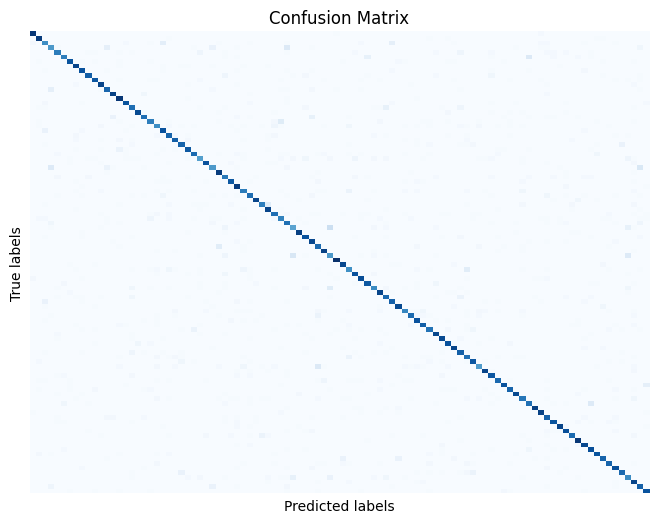

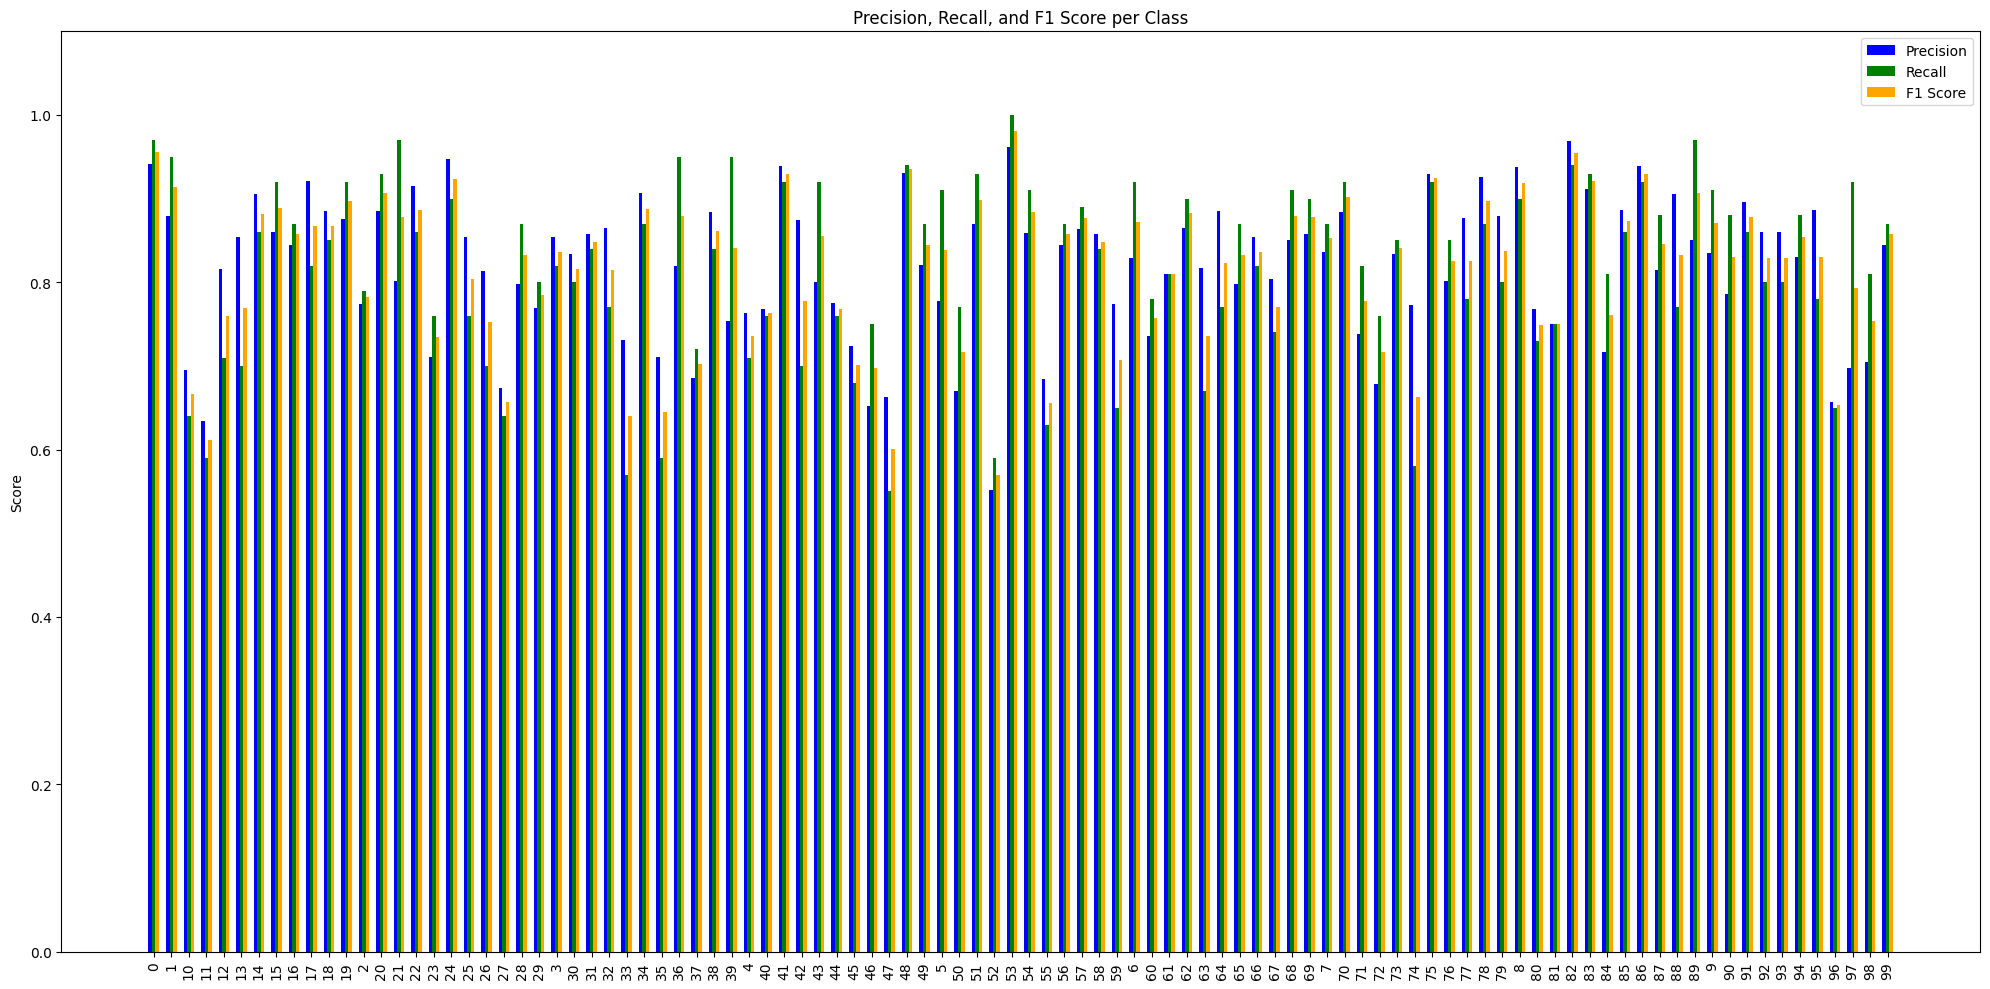

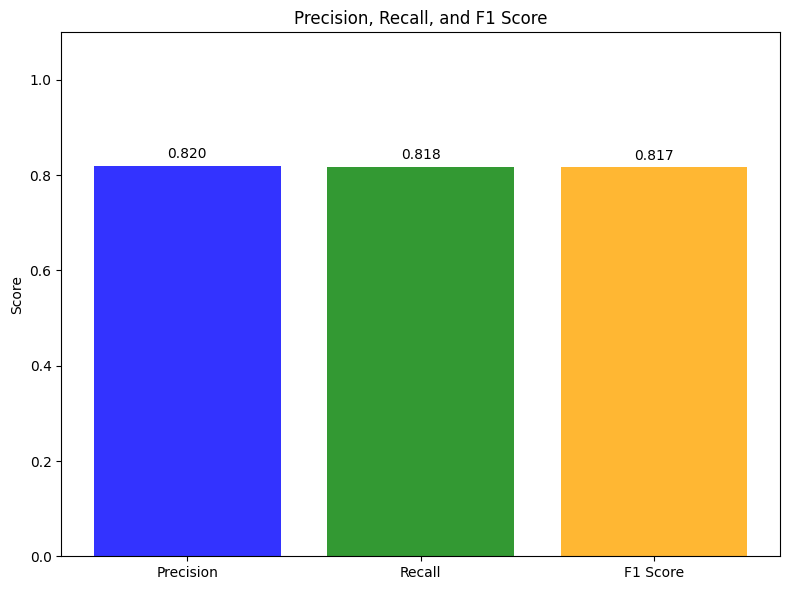

              precision    recall  f1-score   support

           0     0.9417    0.9700    0.9557       100
           1     0.8796    0.9500    0.9135       100
          10     0.6957    0.6400    0.6667       100
          11     0.6344    0.5900    0.6114       100
          12     0.8161    0.7100    0.7594       100
          13     0.8537    0.7000    0.7692       100
          14     0.9053    0.8600    0.8821       100
          15     0.8598    0.9200    0.8889       100
          16     0.8447    0.8700    0.8571       100
          17     0.9213    0.8200    0.8677       100
          18     0.8854    0.8500    0.8673       100
          19     0.8762    0.9200    0.8976       100
           2     0.7745    0.7900    0.7822       100
          20     0.8857    0.9300    0.9073       100
          21     0.8017    0.9700    0.8778       100
          22     0.9149    0.8600    0.8866       100
          23     0.7103    0.7600    0.7343       100
          24     0.9474    

In [6]:
if __name__ == "__main__":
    main()